In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sc
import networkx as ntx
from numpy.random import choice
import scipy.sparse.linalg as spla
import pandas as pd
import inspect
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display
import time
import ipywidgets as widgets
from ipywidgets import interact
from skopt import gp_minimize
from skopt.plots import plot_convergence

Text(0, 0.5, '$Z_{real}$')

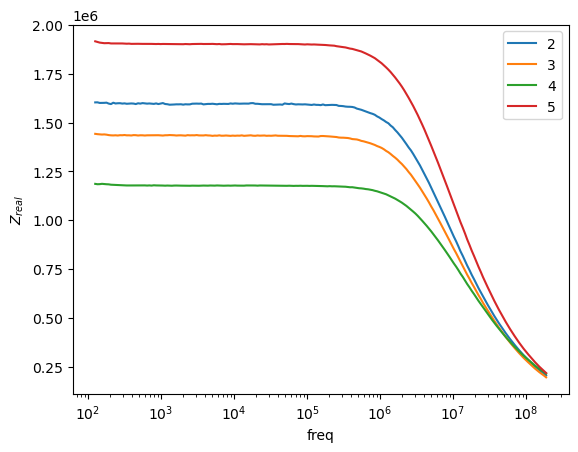

In [13]:
imp = pd.read_csv(f'/home/shardul/impedance_exp/nyquist/Impedance NbMoSe2.csv',delimiter=',')

new_imp = pd.DataFrame()
new_imp["freq"] = pd.to_numeric(imp.dropna(subset = 'ang freq',inplace = False)['ang freq'],errors='coerce').dropna()
new_imp["imp1"] = pd.to_numeric(imp.dropna(subset = 'ReZ',inplace = False)['ReZ'],errors='coerce').dropna()

new_imp["imp2"] = pd.to_numeric(imp.dropna(subset = 'ReZ.1',inplace = False)['ReZ.1'],errors='coerce').dropna()

new_imp["imp3"] = pd.to_numeric(imp.dropna(subset = 'ReZ.2',inplace = False)['ReZ.2'],errors='coerce').dropna()

new_imp["imp4"] = pd.to_numeric(imp.dropna(subset = 'ReZ.3',inplace = False)['ReZ.3'],errors='coerce').dropna()

new_imp["imp5"] = pd.to_numeric(imp.dropna(subset = 'ReZ.4',inplace = False)['ReZ.4'],errors='coerce').dropna()

freq=np.array(new_imp['freq'])
input_data=np.array(new_imp["imp5"])
for x in np.arange(2,6,1):
    plt.semilogx(freq,new_imp[f"imp{x}"],label=f"{x}")
plt.legend()
plt.xlabel('freq')
plt.ylabel(r'$Z_{real}$')

In [ ]:
np.savetxt(f'Desktop/imp1.csv',new_imp["imp5"]/10**5,delimiter=',')

In [ ]:
P= [(i,j) for i in range(1001) for j in range(1001) if i!=j]
def create_graph_from_sample(edges,seed):
    np.random.seed(seed)
    sample_indices = choice(len(P),edges,replace=False)
    sampled_edges = [P[i] for i in sample_indices]
    G= ntx.Graph()
    G.add_edges_from(sampled_edges)
    if len(list(ntx.isolates(G))) == 0:
        return G
    else:
        G.remove_nodes_from(list(ntx.isolates(G)))
    return G

In [5]:
def E0(x):
    m1=[]
    for j in np.arange(0,x*x,x):
        m1.append([(i+j,i+1+j) for i in range(x-1)])
    return np.array(m1).reshape(-1,2) 

def E1(x):
    m1=[]
    for j in np.arange(0,x*x-x,1):
        m1.append((j,x+j))
    return np.array(m1).reshape(-1,2) 
def graph(x):
    G = ntx.Graph()    
    e0 = E0(x)
    e1= E1(x)
    G.add_edges_from(e0)
    G.add_edges_from(e1)        
    return G

In [7]:
def generate_random_values(mean, std, seed, num_edges):
    np.random.seed(seed)
    return np.abs(np.random.normal(mean, std, num_edges))
#create_graph(layers,seed)

In [43]:

# Create epsilon to avoid divide by zero errors
epsilon = 1e-9

# Updated matrix_interactions function
def matrix_interactions(seed, rns, rj,std1,std2, w, size):
    # Create the grid graph
    grid = graph(size)
    grid = ntx.convert_node_labels_to_integers(grid)  # Ensure node labels are 0 to n-1
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()
    
    # Generate random values
    np.random.seed(seed)
    rns = np.abs(generate_random_values(rns, std1, seed, num_edges))
    rj = np.abs(generate_random_values(rj, std2, seed, num_edges))
    cap = np.abs(generate_random_values(10**(-8), 0, seed, num_edges))
    
    # Calculate interactions with a small epsilon to avoid division by zero
    interactions = 1 / (rns + rj / (1 + (cap * rj * w)**2 + epsilon))
    
    # Create the adjacency matrix
    adjM = sc.lil_matrix((nodes, nodes))
    edges = list(grid.edges())
    
    # Fill the adjacency matrix with interaction values
    for edge_idx, (i, j) in enumerate(edges):
        interaction_value = interactions[edge_idx]
        adjM[i, j] = interaction_value
        adjM[j, i] = interaction_value
    
    # Add a small value to the diagonal to ensure it's invertible
    adjM.setdiag(-1 * adjM.sum(axis=1).A1 - 0.0001 + epsilon)
    
    # Convert to CSC format for efficient computations
    adjM_csc = adjM.tocsc()
    
    # Check if the matrix is singular and add a small regularization term if necessary
    try:
        MI = spla.inv(-1 * adjM_csc)
    except RuntimeError:
        print("Matrix is singular, adding small regularization term.")
        adjM.setdiag(adjM.diagonal() + epsilon)
        MI = spla.inv(-1 * adjM.tocsc())
    
    # Calculate the resistance based on the inverse matrix
    resis = MI[0, 0] + MI[nodes-1, nodes-1] - MI[0, nodes-1] - MI[nodes-1, 0]
    return resis

In [ ]:
from skopt.learning.gaussian_process.kernels import Matern

kernel = Matern(nu=2.5)

In [ ]:
space = [(0,10)]

Optimized rns: 0.5585819396021342
Optimized rj: 4.412481961435469


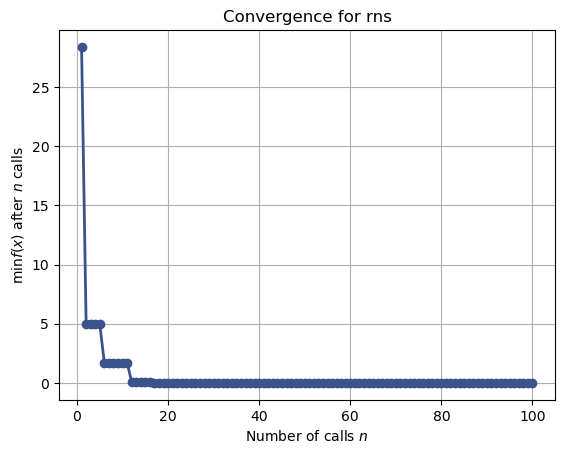

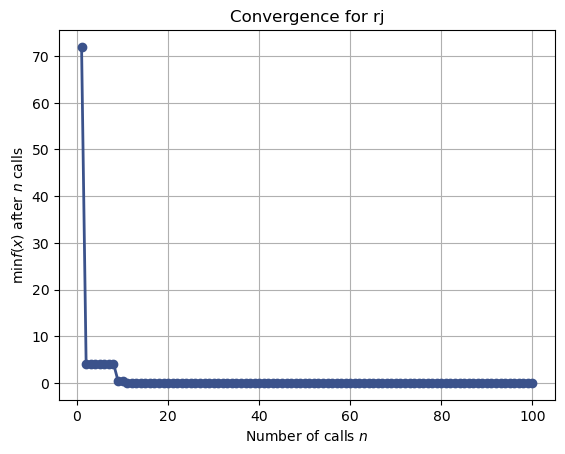

In [15]:
# Step 1: Optimize rns
def min_rns(x):
    # Deriving rns using the last value of freq
    rns_misfit = np.abs(matrix_interactions(1, x, 0, freq[-1], 20) - input_data[-1] / 10**5)
    return rns_misfit

# Step 2: Optimize rj using the optimized rns from Step 1
def min_rj(rj_value, optimized_rns):
    # Deriving rj using the first value of freq, but using optimized rns
    rj_misfit = np.abs(matrix_interactions(1, optimized_rns, rj_value, freq[0], 20) - input_data[0] / 10**5)
    return rj_misfit

# Step 1: Perform Bayesian optimization for rns
space_rns = [(0.0, 10.0)]  # Define search space for rns

result_rns = gp_minimize(min_rns,
                         space_rns,
                         n_calls=100,
                         random_state=42,
                         acq_func="EI",  # Acquisition function (Expected Improvement)
                         noise=1e-8,     # Small noise to make GP more stable
                         n_restarts_optimizer=10)  # Number of restarts in optimizer

# Get the optimized rns value
optimized_rns = result_rns.x[0]
print(f"Optimized rns: {optimized_rns}")

# Step 2: Perform Bayesian optimization for rj using the optimized rns
space_rj = [(0.0, 30.0)]  # Define search space for rj

result_rj = gp_minimize(lambda rj_value: min_rj(rj_value, optimized_rns),
                        space_rj,
                        n_calls=100,
                        random_state=42,
                        acq_func="EI",  # Acquisition function (Expected Improvement)
                        noise=1e-8,     # Small noise to make GP more stable
                        n_restarts_optimizer=10)  # Number of restarts in optimizer

# Get the optimized rj value
optimized_rj = result_rj.x[0]
print(f"Optimized rj: {optimized_rj}")

# Plot the convergence for both rns and rj
plot_convergence(result_rns)
plt.title("Convergence for rns")
plt.show()

plot_convergence(result_rj)
plt.title("Convergence for rj")
plt.show()


In [ ]:
for std in np.arange(0,1.5,0.2):
    print(std)
    df_r[f'{std:2.1f}']= [matrix_interactions(0,0.38,0.1,std,w,60) for w in freq]
    plt.semilogx(freq,df_r[f'{std:2.1f}'],linestyle='dashed',label=f"{std}")

for x in np.arange(2,6,5):
    plt.semilogx(freq,new_imp[f"imp{x}"]/10**5)
plt.legend()
plt.show()

In [ ]:
#for x in np.arange(2,6,1):
#    plt.plot(freq,new_imp[f"imp{x}"]/10**6,label=f"{x}")
#plt.legend()
#plt.xlabel('freq')
#plt.ylabel(r'$Z_{real}$')
#plt.plot(freq,joop,linestyle='dashed')

In [ ]:
matrix_interactions(seed, rns, rj, w)

In [ ]:
dataframes={}

In [ ]:
dataframes2={}

In [ ]:
for rns in np.arange(1.2,1.8, 0.1):
    df_name = f'df_{rns:2.1f}'
    dataframes2[df_name] = pd.DataFrame()
    
    # Nested loop over rj values
    for rj in np.arange(10, 30, 1):
        print(f'rns is :{rns} and rj is :{rj}')
        dataframes2[df_name][f'{rns:2.1f}_mean_{rj:2.1f}_std'] = [
            np.mean([matrix_interactions(seed, rns, rj,8,w) for seed in range(1)]) 
            for w in freq
        ]

In [ ]:
def misf(x):
    misfit1=[]
    for rns in np.arange(1.2, 1.8, 0.1):
        for rj in np.arange(10, 30,1):
            mis1 = np.abs(np.array(dataframes2[f'df_{rns:2.1f}'][f'{rns:2.1f}_mean_{rj:2.1f}_std']) - np.array(new_imp[f"imp{x}"]/10**5))[0:200]
            misfit1.append((rns,rj,mis1.sum()/10**6))
    return misfit1#[np.argmin(misfit1)]

In [ ]:
#(dataframes['df_0.0']['0.0_mean_0.5_std']-np.array(new_imp[f"imp{x}"]/10**5))[100:200]

In [ ]:
misfit_final=[]
for x in np.arange(2,6,1):
    misfit_final.append(np.array(misf(x))[np.argmin(np.array(misf(x))[:,2])])

In [ ]:
misfit_final

In [ ]:
for rj in np.arange(10,30,1):
#    print(std)
#    df_r[f'{std:2.1f}']= [matrix_interactions(0,0.1,1,std,w) for w in freq]
    plt.plot(freq,dataframes2[f'df_{1.2}'][f'{1.2}_mean_{rj:2.1f}_std'],linestyle='dashed')#,label=f"{rj}")

plt.plot(freq,new_imp[f"imp{2}"]/10**5,color='black')
plt.legend()
plt.show()

In [ ]:
def f(r1, r2,w,c,n):
    # Calculate the intermediary terms
    term1 = (w* r2 *c) ** n
    term2 = np.cos(n * np.pi / 2)
    
    # Calculate the numerator
    numerator = r2 * (1 + term1 * term2)
    
    # Calculate the denominator
    denominator = 1 + 2 * term1 * term2 + (w * r2* c) ** (2 * n)
    
    # Calculate the total resistance
    R_total = r1 + (numerator / denominator)
    
    return R_total


In [ ]:
def plot_function(r1,r2, c,n):
    w_values = freq  # Range of w from 0 to 1000
    y_values = [f(r1, r2, w, c*10**(-7),n) for w in w_values]
    
    plt.figure(figsize=(10, 6))
    plt.plot(w_values, y_values, label=f'r2={r2},r1={r1} ,c={c}, z={y_values[200]}',color='black')
    plt.plot(freq,new_imp[f"imp{3}"]/10**5,color='blue',label='Input')
    #plt.xscale('log')
    plt.xlabel('w')
    plt.ylabel(r'$Z_{real}$')
    plt.grid(True)
    plt.legend()
    plt.show()

r1_slider = widgets.FloatSlider(min=1.5, max=2, step=0.01, value=0.01, description='r1')
r2_slider = widgets.FloatSlider(min=11, max=13.6, step=0.1, value=0.1, description='r2')
c_slider = widgets.FloatSlider(min=0, max=0.04, step=0.001, value=0.01, description='c')
n_slider = widgets.FloatSlider(min=0.8, max=1.01, step=0.01, value=0.01, description='n')


interact(plot_function, r1=r1_slider, r2=r2_slider, c=c_slider, n=n_slider)

In [ ]:
cas = {}

In [ ]:

for rns in np.arange(0, 3, 0.1):
    df_name = f'df_{rns:2.1f}'
    cas[df_name] = pd.DataFrame()
    data = {}
    
    for rj in np.arange(0.1, 30, 0.1):
        print(f'rns is :{rns} and rj is :{rj}')
        data[f'{rns:2.1f}_mean_{rj:2.1f}_std'] = [
            np.mean([f(rns, rj, w, 10**(-8)) for seed in range(1)]) 
            for w in freq
        ]
    
    cas[df_name] = pd.DataFrame(data)

In [ ]:
cas['df_0.3']['0.3_mean_0.1_std']

In [ ]:
def misf(x):
    misfit1=[]
    for rns in np.arange(0, 3, 0.1):
        for rj in np.arange(0.1, 30,0.1):
            mis1 = np.abs(np.array(cas[f'df_{rns:2.1f}'][f'{rns:2.1f}_mean_{rj:2.1f}_std']) - np.array(new_imp[f"imp{x}"]/10**5))[0:200]
            misfit1.append((rns,rj,mis1.sum()/10**6))
    return misfit1#[np.argmin(misfit1)]

In [ ]:
misfit_final=[]
for x in np.arange(2,6,1):
    misfit_final.append(np.array(misf(x))[np.argmin(np.array(misf(x))[:,2])])

In [23]:
# Initialize empty lists to store optimized values for rns and rj
optimized_rns_list = []
optimized_rj_list = []

# Iterate over all datapoints in freq array
for i, freq_value in enumerate(freq):
    print(f"Optimizing for freq[{i}] = {freq_value}")
    
    # Step 1: Optimize rns for the current freq value
    def min_rns(x):
        rns_misfit = np.abs(matrix_interactions(1, x, 0, freq_value, 20) - input_data[i] / 10**5)
        return rns_misfit

    space_rns = [(0.0, 10.0)]  # Define search space for rns
    
    result_rns = gp_minimize(min_rns,
                             space_rns,
                             n_calls=100,
                             random_state=42,
                             acq_func="EI",  # Acquisition function (Expected Improvement)
                             noise=1e-8,     # Small noise to make GP more stable
                             n_restarts_optimizer=10)  # Number of restarts in optimizer

    optimized_rns = result_rns.x[0]
    optimized_rns_list.append(optimized_rns)
    
    print(f"Optimized rns for freq[{i}]: {optimized_rns}")
    
    # Step 2: Optimize rj using the optimized rns for the current freq value
    def min_rj(rj_value):
        rj_misfit = np.abs(matrix_interactions(1, optimized_rns, rj_value, freq_value, 20) - input_data[i] / 10**5)
        return rj_misfit

    space_rj = [(0.0, 10.0)]  # Define search space for rj
    
    result_rj = gp_minimize(min_rj,
                            space_rj,
                            n_calls=100,
                            random_state=42,
                            acq_func="EI",  # Acquisition function (Expected Improvement)
                            noise=1e-8,     # Small noise to make GP more stable
                            n_restarts_optimizer=10)  # Number of restarts in optimizer

    optimized_rj = result_rj.x[0]
    optimized_rj_list.append(optimized_rj)
    
    print(f"Optimized rj for freq[{i}]: {optimized_rj}")

# After the loop, you will have two lists: optimized_rns_list and optimized_rj_list

# Print the final lists
print("Optimized rns values:", optimized_rns_list)
print("Optimized rj values:", optimized_rj_list)


Optimizing for freq[0] = 125.66371
Matrix is singular, adding small regularization term.


/tmp/ipykernel_778106/1054202129.py:19: RuntimeWarning: divide by zero encountered in divide
  interactions = 1 / (rns + rj / (1 + (cap * rj * w)**2 + epsilon))


RuntimeError: Factor is exactly singular

In [76]:
from scipy.optimize import minimize
import numpy as np

# Loss function to minimize the difference between derived impedance and actual new_imp values
def impedance_loss(params, freq, new_imp):
    rns, rj, std1, std2 = params  # Parameters we are optimizing
    loss = 0
    for i, freq_value in enumerate(freq):
        derived_impedance = matrix_interactions(1, rns, rj, std1, std2, freq_value, 60)
        actual_impedance = input_data[i] / 10**5  # Normalized new_imp value
        # Sum of squared differences between calculated and actual impedance
        loss += (derived_impedance - actual_impedance)**2
    print(loss)
    return loss

# Callback function to print the current values of rns, rj, std1, and std2
def print_progress(params):
    rns, rj, std1, std2 = params
    print(f"Current values -> rns: {rns}, rj: {rj}, std1: {std1}, std2: {std2}")

# Initial guess for rns, rj, std1, and std2
initial_guess = [1.0, 1.0, 0.5, 0.5]

# Set bounds for rns, rj, std1, and std2 based on expected physical range
bounds = [(0, 10), (0, 30), (0, 10), (0, 50)]  # Adjust bounds as necessary

# Optimization options - increase the number of iterations
options = {'maxiter': 100}  # Set the maximum number of iterations

# Optimize rns, rj, std1, and std2 to fit the impedance values with a callback
result = minimize(impedance_loss, initial_guess, args=(freq, new_imp), method='L-BFGS-B', bounds=bounds, options=options, callback=print_progress)

# Extract optimized values
optimized_rns = result.x[0]
optimized_rj = result.x[1]
optimized_std1 = result.x[2]
optimized_std2 = result.x[3]

print(f"Final optimized values -> rns: {optimized_rns}, rj: {optimized_rj}, std1: {optimized_std1}, std2: {optimized_std2}")


13015.98443574559
13015.984292335193
13015.98428559943
13015.98448441123
13015.984483658864
3014580.189123606
3014580.1874651555
3014580.1878239545
3014580.189221549
3014580.189200926
4870.750696636088
4870.750779618397
4870.750750797876
4870.750685459364
4870.750686852308
Current values -> rns: 1.5368218346377265, rj: 2.7297592449437853, std1: 0.47017656474234854, std2: 0.47017656474234854
2386.6278997740187
2386.627924954129
2386.6279030449086
2386.627896341243
2386.6278973185345
Current values -> rns: 1.309515032662766, rj: 2.288504047246226, std1: 0.4485581170486273, std2: 0.4448691572384686
2154.708944182591
2154.708956828021
2154.7089372145733
2154.7089431149143
2154.7089437151076
Current values -> rns: 1.1879690653832715, rj: 2.2898725011376375, std1: 0.4565154268018495, std2: 0.4466364086301685
1778.9505307751558
1778.9505320311052
1778.9505158007853
1778.9505306848139
1778.950532247953
Current values -> rns: 0.9262156432460987, rj: 2.4658486778576907, std1: 0.4803031961981352,

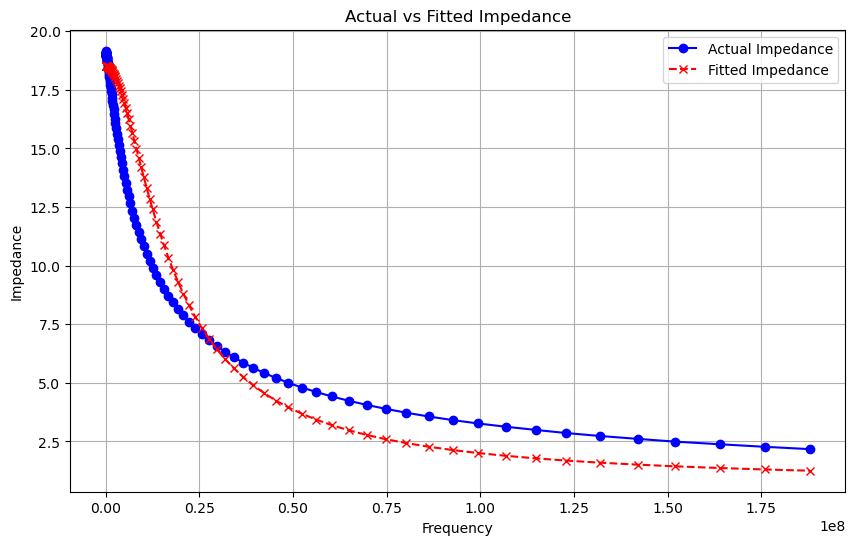

In [77]:
import matplotlib.pyplot as plt

# Assuming 'freq' and 'new_imp' arrays are available

# Example optimized rns and rj values from the earlier optimization
#optimized_rns = 1.5  # Example value, should be replaced by the actual result
#optimized_rj = 2.0   # Example value, should be replaced by the actual result

# Calculate impedance values using the optimized rns and rj
calculated_impedance = [matrix_interactions(1, optimized_rns, optimized_rj,optimized_std1,optimized_std2, f, 60) for f in freq]

# Plot the actual vs calculated impedance values
plt.figure(figsize=(10, 6))

plt.plot(freq, new_imp["imp5"] / 10**5, label="Actual Impedance", marker='o', color='blue')
plt.plot(freq, calculated_impedance, label="Fitted Impedance", linestyle='--', marker='x', color='red')

plt.xlabel('Frequency')
plt.ylabel('Impedance')
plt.title('Actual vs Fitted Impedance')
plt.legend()
plt.grid(True)
plt.show()


In [78]:
print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 288.8531678505563
        x: [ 9.983e-02  3.162e+00  1.740e-01  5.672e+00]
      nit: 43
      jac: [-8.233e-01  5.114e+00 -9.013e-02 -3.219e+00]
     nfev: 620
     njev: 124
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
